# Finnish Forum discussion exploratory language analysis demo

#### Built using a BERT finnish sentiment model by [Nisan Coşkun](https://huggingface.co/nisancoskun/bert-finnish-sentiment-analysis-v2)
#### by Aapo Mikkola, 2025.04.02

# Data & Analysis Overview

This demo uses a BERT model (based on TurkuNLP) to analyze a long discussion from the Finnish forum [vauva.fi](https://www.vauva.fi). The goal is to explore language and sentiment in real forum posts.

- **Data:** One anonymized discussion thread, split into individual posts.
- **Methods:** Topic modeling and sentiment analysis.
- **Purpose:** Showcase exploratory techniques for social science research (TUNI Pro Gradu thesis, unpublished).
- **Privacy:** All data is anonymized, only general statistics and visualizations are provided

In [1]:
# 1) SETUP & IMPORTS

import os
import re
import logging
from collections import Counter
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim import corpora
from gensim.models import LdaMulticore

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import PyPDF2
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

import torch
from wordcloud import WordCloud

# 2) CONFIG & LOGGING

@dataclass
class Config:
    num_topics: int = 5
    pdf_path: str = "vauvaf.pdf"             # change to your PDF
    cache_path: str = "vauvaf_e.txt"         # text cache
    min_doc_len: int = 100                   # min characters to keep a chunk
    split_token: str = "kirjoitti"           # heuristic split token
    embed_model: str = "paraphrase-multilingual-MiniLM-L12-v2"
    kmeans_clusters: int = 8                 # for embedding clusters
    tsne_perplexity_min: int = 5             # lower bound for perplexity
    tsne_perplexity_max: int = 30            # upper bound for perplexity
    batch_size_embed: int = 32               # embedding batch size
    batch_size_sent: int = 16                # sentiment batch size
    make_interactive_html: bool = False      # disable by default in .py runs
    figures_dir: str = "figures"             # where to save PNG/HTML


def setup_logging() -> logging.Logger:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
        handlers=[logging.FileHandler("sentiment_analysis.log"), logging.StreamHandler()],
    )
    return logging.getLogger("nlp-demo")


logger = setup_logging()



l:\Aapo\Code\AI\vauvasentimentanalysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 3) PREPROCESSING HELPERS

# download stopwords (Finnish) once; fallback to empty set
nltk.download("stopwords", quiet=True)
try:
    FINNISH_STOPWORDS = set(stopwords.words("finnish"))
except Exception:
    logger.warning("Finnish stopwords not available, using empty set")
    FINNISH_STOPWORDS = set()

FORUM_STOPWORDS = {
    "Vierailija", "kirjoitti", "reply", "vierailija", "saa", "voi", "thread", "quote",
    "forum", "subject", "edited", "vain", "aina", "edes", "koko", "kaikki", "tulee",
    "joku", "jotain", "miksi", "koska", "sitten", "nyt", "tämä", "tuo", "mitään",
    "myös", "eli", "vaan", "jossa", "jolloin", "kun", "missä", "mikä", "miksi",
    "kuka", "kuitenkin", "kyllä", "ihan", "postaus", "viesti", "vastaus", "vastaa",
    "sanoo", "sanoi", "kerro", "kertoi", "mielestä", "pitää", "pitäisi", "voisi",
    "olisi", "olisin", "olen", "olet", "ovat", "siis", "esim", "jne", "tms", "vielä",
    "silti", "sellaista", "aika", "eikä", "mua",
}
ALL_STOPWORDS = FINNISH_STOPWORDS.union(FORUM_STOPWORDS)


def preprocess_text(text: Any) -> List[str]:
    """Lowercase -> strip punctuation (keep ä,ö,å) -> tokenize -> remove stopwords/short tokens."""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"[^\wäöåÄÖÅ\s]", " ", text)  # keep Finnish chars
    tokens = [t for t in text.split() if t not in ALL_STOPWORDS and len(t) > 2]
    return tokens


def preprocess_for_sentiment(text: Any) -> str:
    """Remove URLs, @mentions, quotes, condense spaces; truncate to 512 chars."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\[quote.*?\[/quote\]", "", text, flags=re.DOTALL)
    text = re.sub(r"\s+", " ", text).strip()
    return text[:512]


def categorize_sentiment(score: float) -> str:
    """Map numeric score to 5 buckets."""
    if score > 0.5:
        return "Very Positive"
    if score > 0.2:
        return "Positive"
    if score > -0.2:
        return "Neutral"
    if score > -0.5:
        return "Negative"
    return "Very Negative"


# 4) DATA LOADING (PDF -> raw text)

def extract_text_from_pdf(pdf_path: str) -> str:
    """Extract text from a PDF file with basic error handling."""
    text = ""
    try:
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for i, page in enumerate(tqdm(reader.pages, desc="Extracting PDF pages")):
                try:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text
                except Exception as e:
                    logger.error(f"Error extracting text from page {i}: {e}")
    except Exception as e:
        logger.error(f"Error opening PDF file: {e}")
    return text


In [3]:
# 5) CORPUS & LDA (training & evaluation)

def build_corpus(documents: List[str]) -> Tuple[corpora.Dictionary, List[List[Tuple[int, int]]], List[List[str]]]:
    """Preprocess -> build dictionary/corpus (bag-of-words)."""
    texts = [preprocess_text(doc) for doc in tqdm(documents, desc="Preprocessing documents")]
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=3, no_above=0.7)  # drop rare/common terms
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus, texts


def train_lda(
    dictionary: corpora.Dictionary,
    corpus: List[List[Tuple[int, int]]],
    num_topics: int = 5,
    random_state: int = 42,
    workers: int = 4,
) -> LdaMulticore:
    """Train LDA (multicore)."""
    lda = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        workers=workers,
        passes=20,
        alpha="asymmetric",
        iterations=100,
    )
    return lda


def evaluate_topic_coherence(
    dictionary: corpora.Dictionary,
    corpus: List[List[Tuple[int, int]]],
    texts: List[List[str]],
    start: int = 2,
    end: int = 15,
    step: int = 1,
    figures_dir: str = "figures",
) -> Tuple[LdaMulticore, List[float], int]:
    """Train many topic counts and compute c_v coherence; return best model + scores."""
    from gensim.models.coherencemodel import CoherenceModel

    os.makedirs(figures_dir, exist_ok=True)
    scores, models = [], []
    k_values = list(range(start, end, step))
    for k in k_values:
        logger.info(f"Training LDA with {k} topics")
        lda = LdaMulticore(
            corpus=corpus, id2word=dictionary, num_topics=k, random_state=42, workers=4, passes=10
        )
        coh = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence="c_v").get_coherence()
        logger.info(f"Topics={k}, Coherence={coh:.4f}")
        scores.append(coh)
        models.append(lda)

    best_idx = int(np.argmax(scores))
    best_k = k_values[best_idx]
    best_model = models[best_idx]

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, scores, marker="o")
    plt.axvline(best_k, color="r", linestyle="--")
    plt.title("Topic Coherence vs #Topics")
    plt.xlabel("Topics")
    plt.ylabel("c_v")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, "topic_coherence.png"))
    plt.close()

    return best_model, scores, best_k


def measure_topic_diversity(lda_model: LdaMulticore, top_n: int = 10) -> float:
    """Jaccard diversity of top-N words across topics (higher is better)."""
    topic_sets = []
    for i in range(lda_model.num_topics):
        words = [w for w, _ in lda_model.show_topic(i, topn=top_n)]
        topic_sets.append(set(words))
    div, cnt = 0.0, 0
    for i in range(len(topic_sets)):
        for j in range(i + 1, len(topic_sets)):
            inter = len(topic_sets[i] & topic_sets[j])
            union = len(topic_sets[i] | topic_sets[j])
            div += 1 - (inter / union)
            cnt += 1
    return div / cnt if cnt else 0.0


In [4]:
# 6) TOPIC VISUALIZATIONS

def create_wordcloud_by_topic(lda_model: LdaMulticore, num_words: int = 20, figures_dir: str = "figures") -> None:
    """Word cloud per topic (saved to PNG)."""
    os.makedirs(figures_dir, exist_ok=True)
    for topic_id in range(lda_model.num_topics):
        topic_words = dict(lda_model.show_topic(topic_id, topn=num_words))
        wc = WordCloud(
            width=800, height=400, background_color="white", colormap="viridis", max_words=num_words
        ).generate_from_frequencies(topic_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud — Topic {topic_id}")
        plt.tight_layout()
        plt.savefig(os.path.join(figures_dir, f"wordcloud_topic_{topic_id}.png"))
        plt.close()


def plot_top_words(lda_model: LdaMulticore, topic_id: int, num_words: int = 20) -> None:
    """Bar chart of top words for a given topic."""
    topic = lda_model.show_topic(topic_id, topn=num_words)
    words, weights = zip(*topic)
    plt.figure(figsize=(12, 4))
    plt.bar(words, weights, color="skyblue")
    plt.title(f"Top {num_words} words — Topic {topic_id}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def create_wordcloud_by_topic(lda_model, dictionary, num_words: int = 20, figures_dir: str = "figures") -> None:
    """
    Create and save a word cloud PNG for each topic.

    Parameters
    ----------
    lda_model : gensim.models.LdaMulticore
        Trained LDA model.
    dictionary : gensim.corpora.Dictionary
        (Unused here; kept for API compatibility with your previous code.)
    num_words : int
        Top-N words per topic to visualize.
    figures_dir : str
        Output directory for images.
    """
    os.makedirs(figures_dir, exist_ok=True)

    for topic_id in range(lda_model.num_topics):
        topic_words = dict(lda_model.show_topic(topic_id, topn=num_words))
        wc = WordCloud(
            width=800, height=400,
            background_color="white",
            colormap="viridis",
            max_words=num_words
        ).generate_from_frequencies(topic_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud — Topic {topic_id}")
        plt.tight_layout()
        plt.savefig(os.path.join(figures_dir, f"wordcloud_topic_{topic_id}.png"))
        plt.close()


def plot_topic_distribution(
    lda_model: LdaMulticore, corpus: List[List[Tuple[int, int]]], figures_dir: str = "figures"
) -> np.ndarray:
    """Average topic weights + heatmap of first 100 docs."""
    os.makedirs(figures_dir, exist_ok=True)

    topic_dists = []
    for bow in corpus:
        dist = lda_model.get_document_topics(bow)
        full = [0.0] * lda_model.num_topics
        for tid, w in dist:
            full[tid] = w
        topic_dists.append(full)
    M = np.array(topic_dists)
    avg = M.mean(axis=0)

    plt.figure(figsize=(8, 5))
    plt.bar(range(lda_model.num_topics), avg, color=plt.cm.tab10.colors[: lda_model.num_topics])
    labels = []
    for i in range(lda_model.num_topics):
        top = [w for w, _ in lda_model.show_topic(i, topn=3)]
        labels.append(f"Topic {i}\n({', '.join(top)})")
    plt.xticks(range(lda_model.num_topics), labels, rotation=45, ha="right")
    plt.title("Average Topic Distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, "topic_distribution.png"))
    plt.close()

    plt.figure(figsize=(10, 6))
    dom = np.argmax(M, axis=1)
    order = np.argsort(dom)
    sns.heatmap(
        M[order][:100],
        cmap="viridis",
        vmin=0,
        vmax=1,
        xticklabels=[f"T{i}" for i in range(lda_model.num_topics)],
    )
    plt.title("Topic Weights (first 100 docs)")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, "topic_heatmap.png"))
    plt.close()
    return M


# 7) EMBEDDINGS & CLUSTERING

def compute_semantic_embeddings(
    documents: List[str], model_name: str, batch_size: int = 32
) -> np.ndarray:
    """Compute dense sentence embeddings (batching)."""
    logger.info(f"Computing embeddings with {model_name}")
    try:
        embedder = SentenceTransformer(model_name)
        embs = []
        for i in tqdm(range(0, len(documents), batch_size), desc="Embedding batches"):
            batch = documents[i : i + batch_size]
            embs.append(embedder.encode(batch, show_progress_bar=False))
        return np.vstack(embs) if embs else np.zeros((0, 384), dtype=np.float32)
    except Exception as e:
        logger.error(f"Embedding failed: {e}")
        # last-resort random embeddings to keep plots working
        dim = 512
        return np.random.rand(len(documents), dim)


def cluster_embeddings(embeddings: np.ndarray, num_clusters: int = 8, random_state: int = 42) -> np.ndarray:
    """KMeans clustering on embeddings; return labels."""
    if len(embeddings) == 0:
        return np.array([], dtype=int)
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=10)
    return kmeans.fit_predict(embeddings)


def plot_embedding_clusters(embeddings: np.ndarray, labels: np.ndarray, sentiments: Optional[List[float]] = None) -> None:
    """PCA 2D plot; color by cluster or by sentiment."""
    if len(embeddings) == 0:
        logger.warning("No embeddings to plot.")
        return
    X = PCA(n_components=2).fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    if sentiments is None:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
        plt.colorbar(scatter, label="Cluster")
        plt.title("Embeddings (PCA) by Cluster")
    else:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=sentiments, cmap="coolwarm", alpha=0.7)
        plt.colorbar(scatter, label="Sentiment")
        plt.title("Embeddings (PCA) with Sentiment")
    plt.tight_layout()
    plt.show()


def plot_tsne_clusters(
    embeddings: np.ndarray, labels: np.ndarray, sentiments: Optional[List[float]] = None, cfg: Optional[Config] = None
) -> None:
    """t-SNE 2D plot; color by cluster or by sentiment."""
    if len(embeddings) == 0:
        logger.warning("No embeddings for t-SNE.")
        return
    n = len(embeddings)
    if cfg is None:
        p = max(5, min(30, n // 10))
    else:
        p = max(cfg.tsne_perplexity_min, min(cfg.tsne_perplexity_max, n // 10 if n >= 10 else cfg.tsne_perplexity_min))
    tsne = TSNE(n_components=2, random_state=42, perplexity=p)
    X = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    if sentiments is None:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
        plt.colorbar(scatter, label="Cluster")
        plt.title("t-SNE of Embeddings by Cluster")
    else:
        scatter = plt.scatter(X[:, 0], X[:, 1], c=sentiments, cmap="coolwarm", alpha=0.7)
        plt.colorbar(scatter, label="Sentiment")
        plt.title("t-SNE of Embeddings with Sentiment")
    plt.tight_layout()
    plt.show()


def compute_cluster_sentiments(sentiments: List[float], labels: np.ndarray, num_clusters: int) -> List[float]:
    """Average sentiment per cluster (by label id)."""
    avg = []
    for i in range(num_clusters):
        vals = [s for s, lab in zip(sentiments, labels) if lab == i]
        avg.append(float(np.mean(vals)) if vals else 0.0)
    return avg


# 8) SENTIMENT MODEL

def initialize_finnish_sentiment_model():
    """Initialize a Finnish (or multilingual fallback) sentiment pipeline."""
    logger.info("Initializing sentiment model")
    device = 0 if torch.cuda.is_available() else -1
    try:
        model_name = "nisancoskun/bert-finnish-sentiment-analysis-v2"
        tok = AutoTokenizer.from_pretrained(model_name)
        mdl = AutoModelForSequenceClassification.from_pretrained(model_name)
        analyzer = pipeline("sentiment-analysis", model=mdl, tokenizer=tok, device=device)
        logger.info("Loaded nisancoskun/bert-finnish-sentiment-analysis-v2")
        return analyzer, "finnish"
    except Exception as e:
        logger.warning(f"Finnish model failed: {e}")
        try:
            analyzer = pipeline(
                "sentiment-analysis",
                model="nlptown/bert-base-multilingual-uncased-sentiment",
                device=device,
            )
            logger.info("Using multilingual fallback")
            return analyzer, "multilingual"
        except Exception as e2:
            logger.warning(f"Multilingual model failed: {e2}")
            try:
                base = "TurkuNLP/bert-base-finnish-cased-v1"
                tok = AutoTokenizer.from_pretrained(base)
                mdl = AutoModelForSequenceClassification.from_pretrained(
                    base, num_labels=3, ignore_mismatched_sizes=True
                )
                analyzer = pipeline("text-classification", model=mdl, tokenizer=tok, device=device)
                logger.info("Using TurkuNLP base model with classification head")
                return analyzer, "turku"
            except Exception as e3:
                logger.error(f"All sentiment models failed: {e3}")

                def dummy(texts, **kwargs):
                    if isinstance(texts, list):
                        return [{"label": "NEUTRAL", "score": 0.5} for _ in texts]
                    return {"label": "NEUTRAL", "score": 0.5}

                return dummy, "dummy"


def normalize_sentiment_score(result: Any, model_type: str) -> float:
    """Normalize various model outputs to [-1, 1]."""
    if model_type == "finnish":
        r = result[0] if isinstance(result, list) and result else result
        label = r.get("label", "NEUTRAL")
        score = float(r.get("score", 0.5))
        if label in ["LABEL_0", "0", 0, "negative"] or ("neg" in str(label).lower()):
            return -score
        if label in ["LABEL_2", "2", 2, "positive"] or ("pos" in str(label).lower()):
            return score
        return 0.0
    if model_type == "multilingual":
        lab = result.get("label", "")
        if isinstance(lab, str) and "star" in lab.lower():
            stars = int(lab.split()[0])
            return (stars - 3) / 2.0
        return 0.0
    if model_type == "turku":
        lab = result.get("label", "LABEL_1")
        sc = float(result.get("score", 0.5))
        return -sc if lab == "LABEL_0" else (sc if lab == "LABEL_2" else 0.0)
    return 0.0


def batch_sentiment_analysis(
    documents: List[str], analyzer, model_type: str, batch_size: int = 16
) -> Tuple[List[float], List[Any]]:
    """Run sentiment analysis in batches; return scores and raw results."""
    logger.info(f"Batch sentiment with model={model_type}")
    clean = [preprocess_for_sentiment(d) for d in tqdm(documents, desc="Preprocess for sentiment")]
    dataset = Dataset.from_dict({"text": clean})

    def _proc(batch):
        try:
            texts = [t for t in batch["text"] if t.strip()]
            if not texts:
                n = len(batch["text"])
                return {"sentiment": [0.0] * n, "raw_result": [None] * n}
            res = analyzer(texts, truncation=True)
            out_s, out_r = [], []
            j = 0
            for t in batch["text"]:
                if t.strip():
                    r = res[j]
                    j += 1
                    out_s.append(normalize_sentiment_score(r, model_type))
                    out_r.append(r)
                else:
                    out_s.append(0.0)
                    out_r.append(None)
            return {"sentiment": out_s, "raw_result": out_r}
        except Exception as e:
            logger.error(f"Batch sentiment error: {e}")
            n = len(batch["text"])
            return {"sentiment": [0.0] * n, "raw_result": [None] * n}

    processed = dataset.map(_proc, batched=True, batch_size=batch_size, desc="Analyzing sentiment")
    return processed["sentiment"], processed["raw_result"]


# 9) TOPIC–SENTIMENT VISUALIZATIONS

def plot_topic_sentiment_visualization(
    documents: List[str],
    lda_model: LdaMulticore,
    corpus: List[List[Tuple[int, int]]],
    sentiments: List[float],
    cfg: Config,
    do_tsne: bool = True,
    do_boxplot: bool = True,
) -> None:
    """Two plots: t-SNE colored by topic & sentiment; and boxplot of sentiment per topic."""
    # dominant topic per doc
    doc_topics = []
    for bow in corpus:
        dist = lda_model.get_document_topics(bow)
        dom = sorted(dist, key=lambda x: x[1], reverse=True)[0][0] if dist else 0
        doc_topics.append(dom)

    df = pd.DataFrame({"text": documents, "topic": doc_topics, "sentiment": sentiments})

    # topic keywords for labels
    topic_kw = {}
    for tid in range(lda_model.num_topics):
        topw = [w for w, _ in lda_model.show_topic(tid, topn=3)]
        topic_kw[tid] = f"Topic {tid}: {', '.join(topw)}"

    if do_tsne:
        embs = compute_semantic_embeddings(documents, cfg.embed_model, cfg.batch_size_embed)
        n = len(embs)
        p = max(cfg.tsne_perplexity_min, min(cfg.tsne_perplexity_max, n // 10 if n >= 10 else cfg.tsne_perplexity_min))
        tsne = TSNE(n_components=2, random_state=42, perplexity=p)
        X = tsne.fit_transform(embs)
        plt.figure(figsize=(12, 10))
        pos = np.array(sentiments) >= 0
        neg = ~pos
        cmap = plt.cm.tab10.colors
        for tid in range(lda_model.num_topics):
            mask_pos = (np.array(doc_topics) == tid) & pos
            if np.any(mask_pos):
                plt.scatter(
                    X[mask_pos, 0],
                    X[mask_pos, 1],
                    c=[cmap[tid % len(cmap)]],
                    s=(np.array(sentiments)[mask_pos] + 1) * 50,
                    marker="^",
                    label=f"{topic_kw[tid]} (positive)",
                )
            mask_neg = (np.array(doc_topics) == tid) & neg
            if np.any(mask_neg):
                plt.scatter(
                    X[mask_neg, 0],
                    X[mask_neg, 1],
                    c=[cmap[tid % len(cmap)]],
                    s=(1 - np.array(sentiments)[mask_neg]) * 50,
                    marker="v",
                    label=f"{topic_kw[tid]} (negative)",
                )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.title("Document Sentiment by Topic (t-SNE)")
        plt.tight_layout()
        os.makedirs(cfg.figures_dir, exist_ok=True)
        plt.savefig(os.path.join(cfg.figures_dir, "topic_sentiment_tsne.png"))
        plt.show()

    if do_boxplot:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="topic", y="sentiment", data=df, palette="tab10")
        plt.xticks(
            range(lda_model.num_topics),
            [topic_kw[i] for i in range(lda_model.num_topics)],
            rotation=45,
            ha="right",
        )
        plt.axhline(0, color="red", linestyle="--", alpha=0.6)
        plt.title("Sentiment per Topic")
        plt.tight_layout()
        os.makedirs(cfg.figures_dir, exist_ok=True)
        plt.savefig(os.path.join(cfg.figures_dir, "topic_sentiment_boxplot.png"))
        plt.show()




2025-08-12 20:05:11,310 - nlp-demo - INFO - Number of documents: 1110
Preprocessing documents: 100%|██████████| 1110/1110 [00:00<00:00, 27065.69it/s]
2025-08-12 20:05:11,424 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2025-08-12 20:05:11,464 - gensim.corpora.dictionary - INFO - built Dictionary<16926 unique tokens: ['asumistukea', 'elatusmaksuja', 'heti', 'hyvä', 'hyvät']...> from 1110 documents (total 86311 corpus positions)
2025-08-12 20:05:11,465 - gensim.utils - INFO - Dictionary lifecycle event {'msg': "built Dictionary<16926 unique tokens: ['asumistukea', 'elatusmaksuja', 'heti', 'hyvä', 'hyvät']...> from 1110 documents (total 86311 corpus positions)", 'datetime': '2025-08-12T20:05:11.465090', 'gensim': '4.3.3', 'python': '3.12.9 (main, Mar 17 2025, 21:06:20) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}
2025-08-12 20:05:11,472 - gensim.corpora.dictionary - INFO - discarding 11728 tokens: 

Topic 0:
0.010*"varaa" + 0.008*"miten" + 0.008*"tukea" + 0.007*"yhtään" + 0.007*"asumistukea" + 0.007*"lapsilisää" + 0.007*"rahaa" + 0.006*"perheet" + 0.006*"ruokaan" + 0.006*"elatusmaksuja"

Topic 1:
0.012*"talvikengät" + 0.007*"lasten" + 0.006*"rukkaset" + 0.005*"ettei" + 0.005*"lapsi" + 0.005*"jouluruokaa" + 0.005*"sadetakki" + 0.005*"villahaalari" + 0.005*"sukkia" + 0.005*"lämpimät"

Topic 2:
0.010*"rahaa" + 0.008*"perheen" + 0.008*"vaatteita" + 0.006*"toiveet" + 0.005*"menot" + 0.005*"lapsi" + 0.004*"tyttö" + 0.004*"kokoa" + 0.004*"lapsen" + 0.004*"lelut"

Topic 3:
0.009*"rahaa" + 0.008*"netflix" + 0.007*"välillä" + 0.006*"omasta" + 0.006*"paljon" + 0.005*"katsoa" + 0.005*"saan" + 0.004*"lahjoja" + 0.004*"pyytää" + 0.004*"ottaa"

Topic 4:
0.008*"paljon" + 0.005*"köyhyyttä" + 0.005*"sijaan" + 0.005*"lähes" + 0.005*"kestää" + 0.005*"muutama" + 0.004*"saisi" + 0.004*"rahaa" + 0.004*"ruokaa" + 0.004*"ennen"



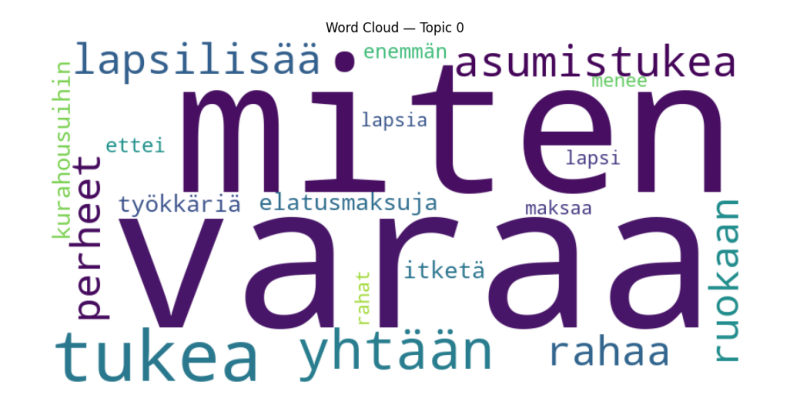

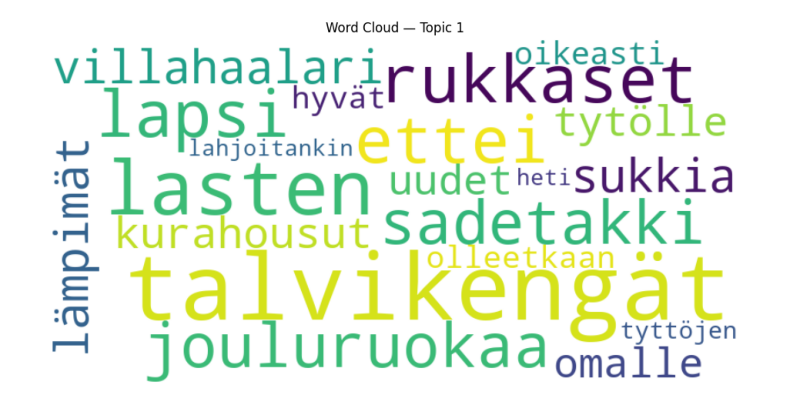

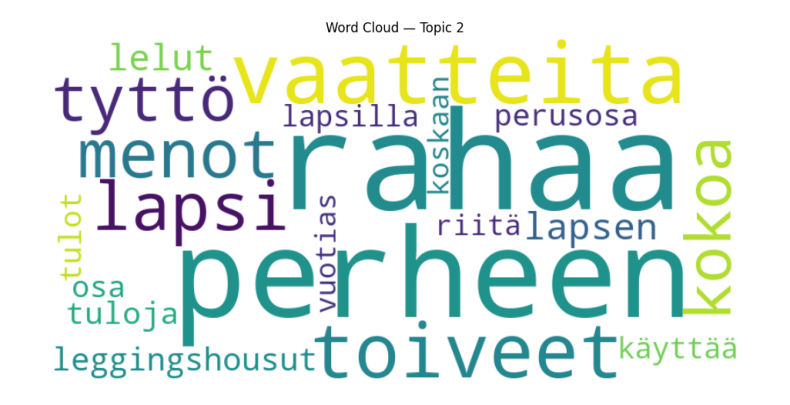

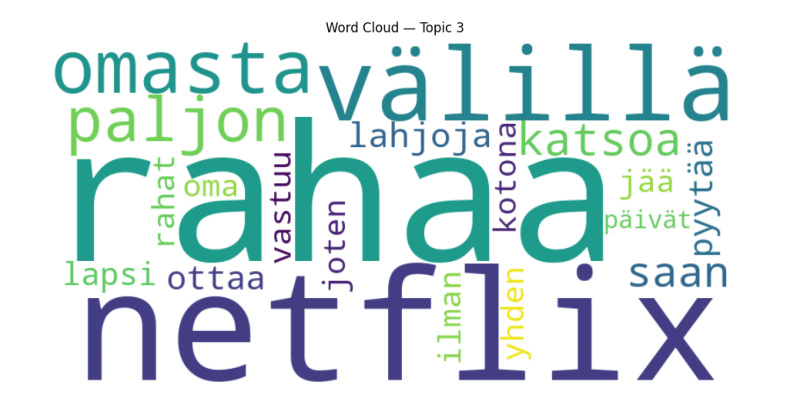

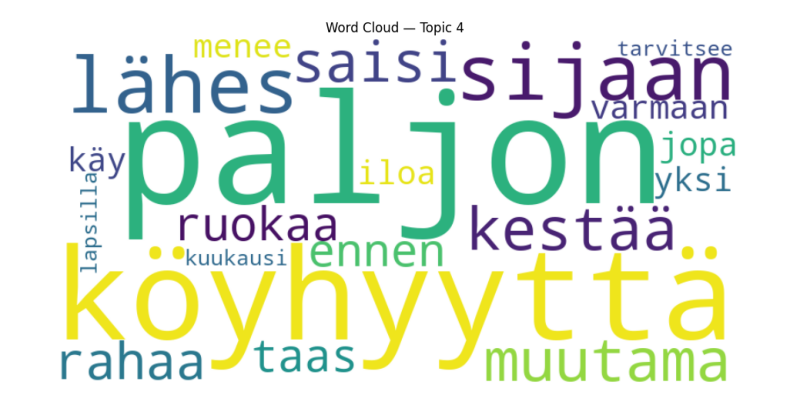

2025-08-12 20:05:23,508 - nlp-demo - INFO - Computing embeddings with paraphrase-multilingual-MiniLM-L12-v2
2025-08-12 20:05:23,511 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-08-12 20:05:23,511 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2


Topic diversity: 0.9573


Embedding batches: 100%|██████████| 35/35 [00:14<00:00,  2.39it/s]


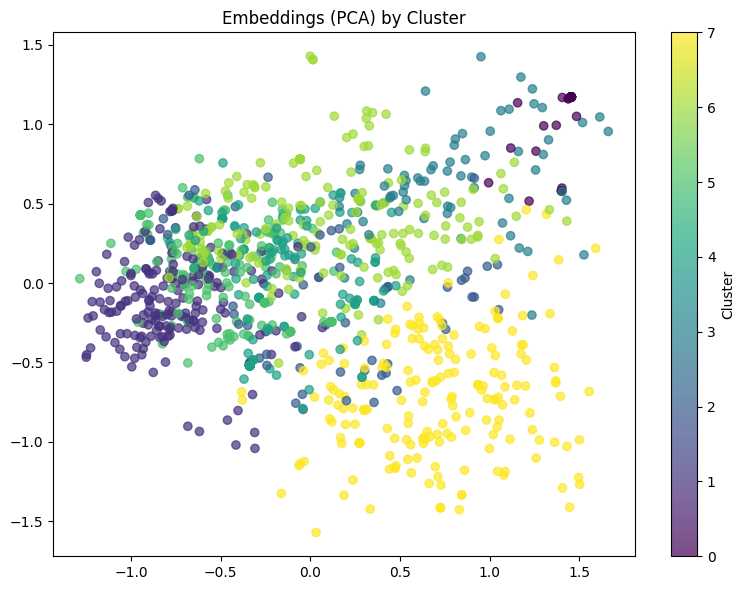

2025-08-12 20:05:42,486 - nlp-demo - INFO - Initializing sentiment model
Device set to use cpu
2025-08-12 20:05:43,695 - nlp-demo - INFO - Loaded nisancoskun/bert-finnish-sentiment-analysis-v2
2025-08-12 20:05:43,696 - nlp-demo - INFO - Batch sentiment with model=finnish
Analyzing sentiment: 100%|██████████| 1110/1110 [00:48<00:00, 23.05 examples/s]


Average sentiment: -0.8470531509266244
Average sentiment per cluster: [-0.8890841347830636, -0.9897192446226927, -0.8065835670117409, -0.6234060372625079, -0.9748445273908369, -0.9808838028393819, -0.6918436045895255, -0.7440993364613789]


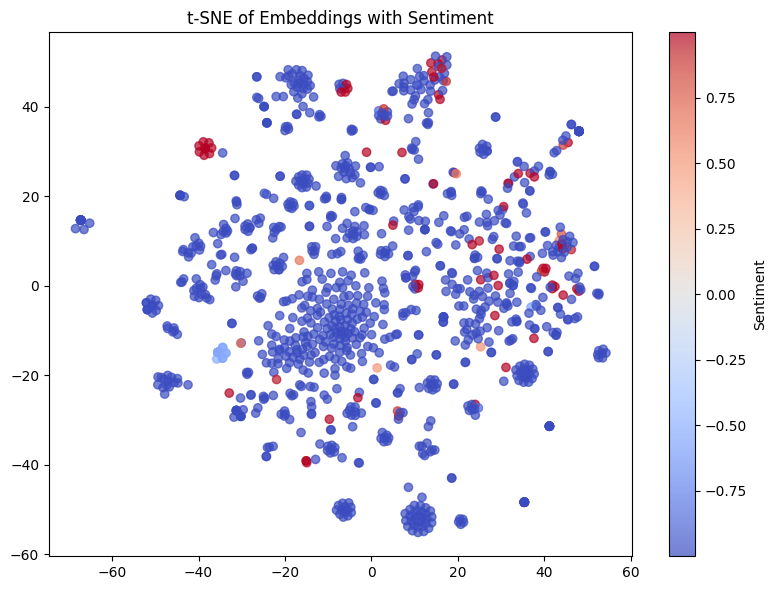

2025-08-12 20:06:34,960 - nlp-demo - INFO - Computing embeddings with paraphrase-multilingual-MiniLM-L12-v2
2025-08-12 20:06:34,963 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2025-08-12 20:06:34,964 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
Embedding batches: 100%|██████████| 35/35 [00:15<00:00,  2.33it/s]


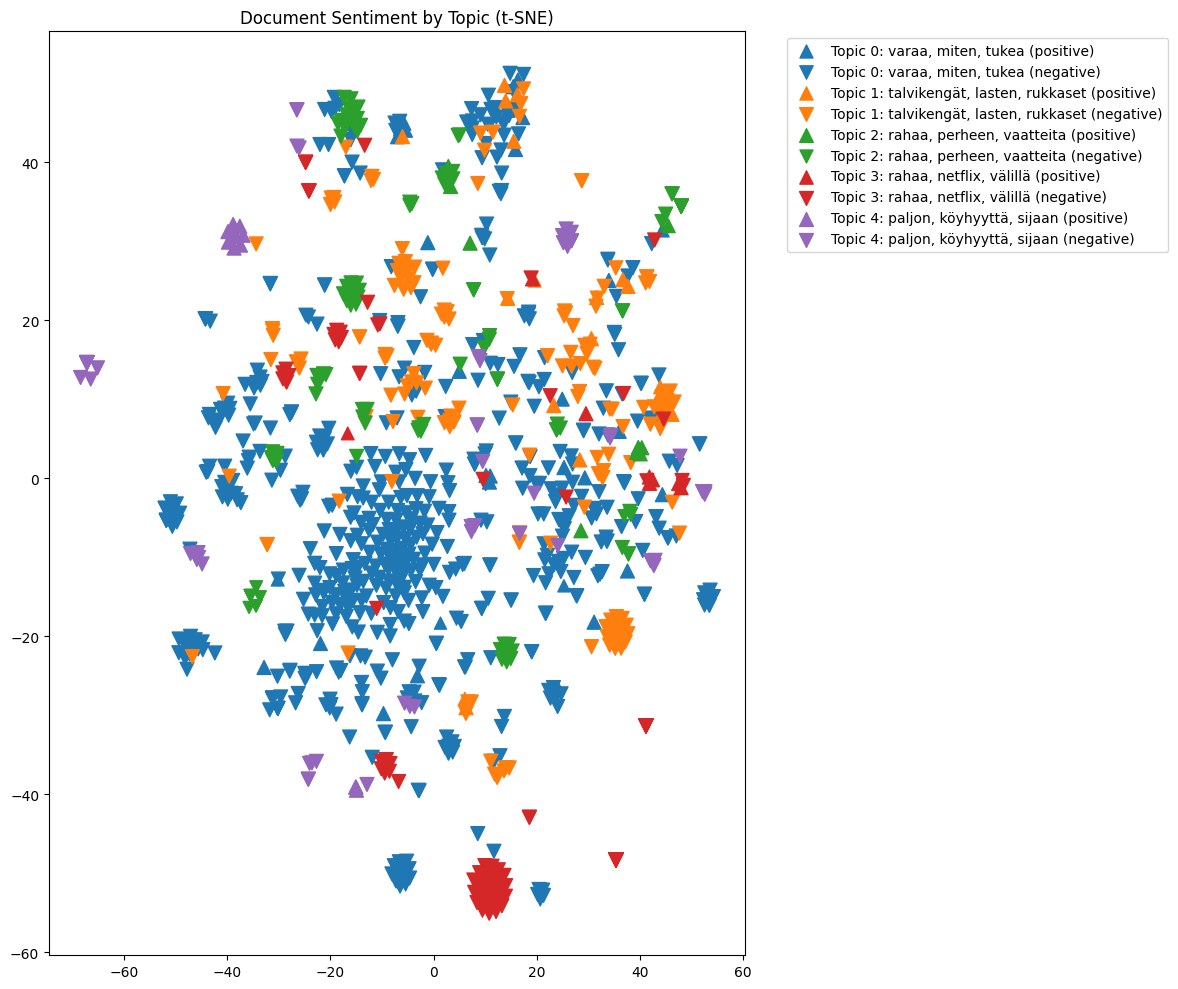

In [5]:
# 10) RUN PIPELINE 

def main(cfg: Config) -> None:
    # create figures dir
    os.makedirs(cfg.figures_dir, exist_ok=True)

    # a) Load text (PDF -> cache)
    if os.path.exists(cfg.cache_path):
        with open(cfg.cache_path, "r", encoding="utf-8") as f:
            pdf_text = f.read()
    else:
        if not os.path.exists(cfg.pdf_path):
            logger.warning(f"PDF not found: {cfg.pdf_path}. Using empty text.")
            pdf_text = ""
        else:
            pdf_text = extract_text_from_pdf(cfg.pdf_path)
        with open(cfg.cache_path, "w", encoding="utf-8") as f:
            f.write(pdf_text)

    # b) Split into documents and keep only sufficiently long chunks
    documents = [d for d in pdf_text.split(cfg.split_token) if len(d) > cfg.min_doc_len]
    if not documents:
        logger.warning("No documents extracted; creating small dummy corpus to keep pipeline running.")
        documents = [
            "Tämä on esimerkkiteksti. Tämä liittyy data-analyysiin ja koneoppimiseen.",
            "Toinen ketju käsittelee luonnollisen kielen käsittelyä ja mallintamista.",
            "Yleisö keskustelee tunteista, mielipiteistä ja kokemuksista eri aiheista.",
            "Lopuksi tarkastelemme aiheita, klustereita sekä sentimenttiä.",
        ]
    logger.info(f"Number of documents: {len(documents)}")

    # c) Save HF dataset and add tokens
    dataset = Dataset.from_dict({"text": documents})

    def add_tokens(ex):
        ex["tokens"] = preprocess_text(ex["text"])
        return ex

    dataset = dataset.map(add_tokens)
    processed_documents = dataset["text"]  # keep original text for LDA bag-of-words

    # d) Build corpus & train LDA (ensure order to avoid NameError)
    dictionary, corpus, texts = build_corpus(processed_documents)
    lda_model = train_lda(dictionary, corpus, num_topics=cfg.num_topics, workers=4)

    # e) Show topics & topic visuals
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}:\n{topic}\n")

    create_wordcloud_by_topic(lda_model, dictionary, num_words=20, figures_dir=cfg.figures_dir)
    for topic_id in range(lda_model.num_topics):
        img_path = os.path.join(cfg.figures_dir, f"wordcloud_topic_{topic_id}.png")
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

    diversity = measure_topic_diversity(lda_model)
    print(f"Topic diversity: {diversity:.4f}")

    # f) Embeddings & clusters
    embeddings = compute_semantic_embeddings(processed_documents, cfg.embed_model, cfg.batch_size_embed)
    cluster_labels = cluster_embeddings(embeddings, num_clusters=cfg.kmeans_clusters)
    plot_embedding_clusters(embeddings, cluster_labels)

    # g) Sentiment model & batch analysis
    analyzer, model_type = initialize_finnish_sentiment_model()
    sentiments, raw_results = batch_sentiment_analysis(processed_documents, analyzer, model_type, cfg.batch_size_sent)
    print("Average sentiment:", float(np.mean(sentiments)))

    # h) Cluster-level sentiment
    cluster_avg = compute_cluster_sentiments(sentiments, cluster_labels, num_clusters=cfg.kmeans_clusters)
    print("Average sentiment per cluster:", cluster_avg)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(cluster_avg)), cluster_avg, color="salmon")
    plt.xlabel("Cluster")
    plt.ylabel("Avg Sentiment")
    plt.title("Avg Sentiment per Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.figures_dir, "sentiment_per_cluster.png"))
    plt.close()

    # i) Topic–sentiment combined viz
    plot_tsne_clusters(embeddings, cluster_labels, sentiments=sentiments, cfg=cfg)
    plot_topic_sentiment_visualization(processed_documents, lda_model, corpus, sentiments, cfg, do_tsne=True, do_boxplot=False)


if __name__ == "__main__":
    # Only edit these if you want to change defaults, order is fixed to avoid NameError issues.
    cfg = Config(
        num_topics=5,
        pdf_path="vauvaf.pdf",            # set your PDF
        cache_path="vauvaf_e.txt",
        min_doc_len=100,
        split_token="kirjoitti",
        embed_model="paraphrase-multilingual-MiniLM-L12-v2",
        kmeans_clusters=8,
        make_interactive_html=False,      # HTML disabled in .py run
        figures_dir="figures",
    )
    # Reproducibility
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.manual_seed(42)

    main(cfg)

# Conclusion

Topics indicate clear themes around financial hardship and social support (Topic 0, 4), children’s winter clothing / practical needs (Topic 1), family expenses and gifts (Topic 2), and trade-offs around entertainment spending (Netflix) and money (Topic 3).

Topic diversity = 0.9573, topics are well separated (low lexical overlap).

Average sentiment ≈ −0.85, the corpus is strongly negative overall.

All clusters are negative, the least negative cluster is around −0.62, while several are near −0.98 to −0.99, suggesting that conversations frequently express stress, scarcity, or dissatisfaction, with only small pockets that are relatively less negative.